In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# fitting_type = 'gabor_solo_ridge_12ori_8sf'
fitting_type = 'gabor_solo_ridge_12ori_8sf_SHUFFLEIMAGES'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf_SHUFFLEIMAGES/Nov-07-2021_1513_18/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'discrim_each_axis', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'autocorr_output_pix', 'group_all_hl_feats'])
subject = 1
volume_space = 1
fitting_type = gabor_solo
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (15000,)


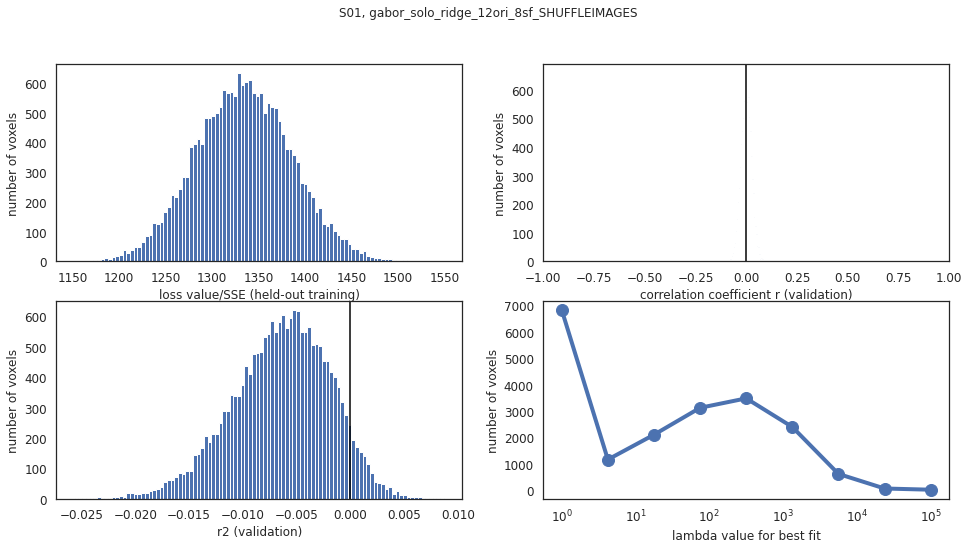

In [212]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [5]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [15]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, roi_def=roi_def, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


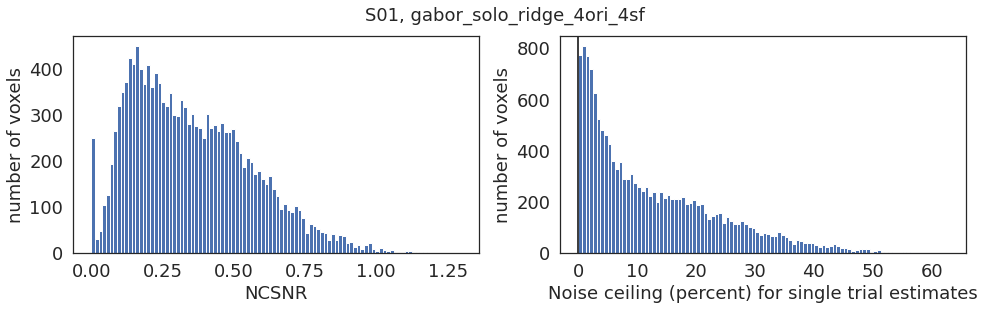

In [8]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

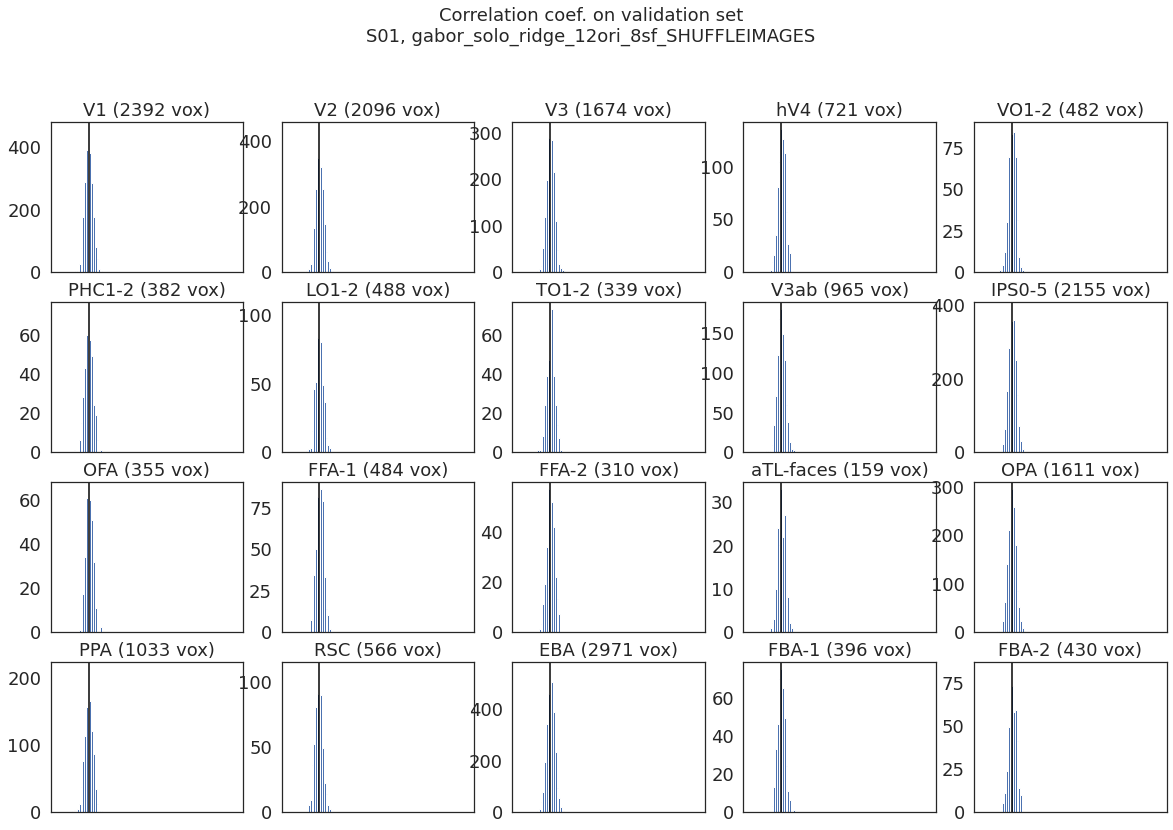

In [214]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                               fig_save_folder=fig_save_folder)

In [9]:
len(roi_def)

8

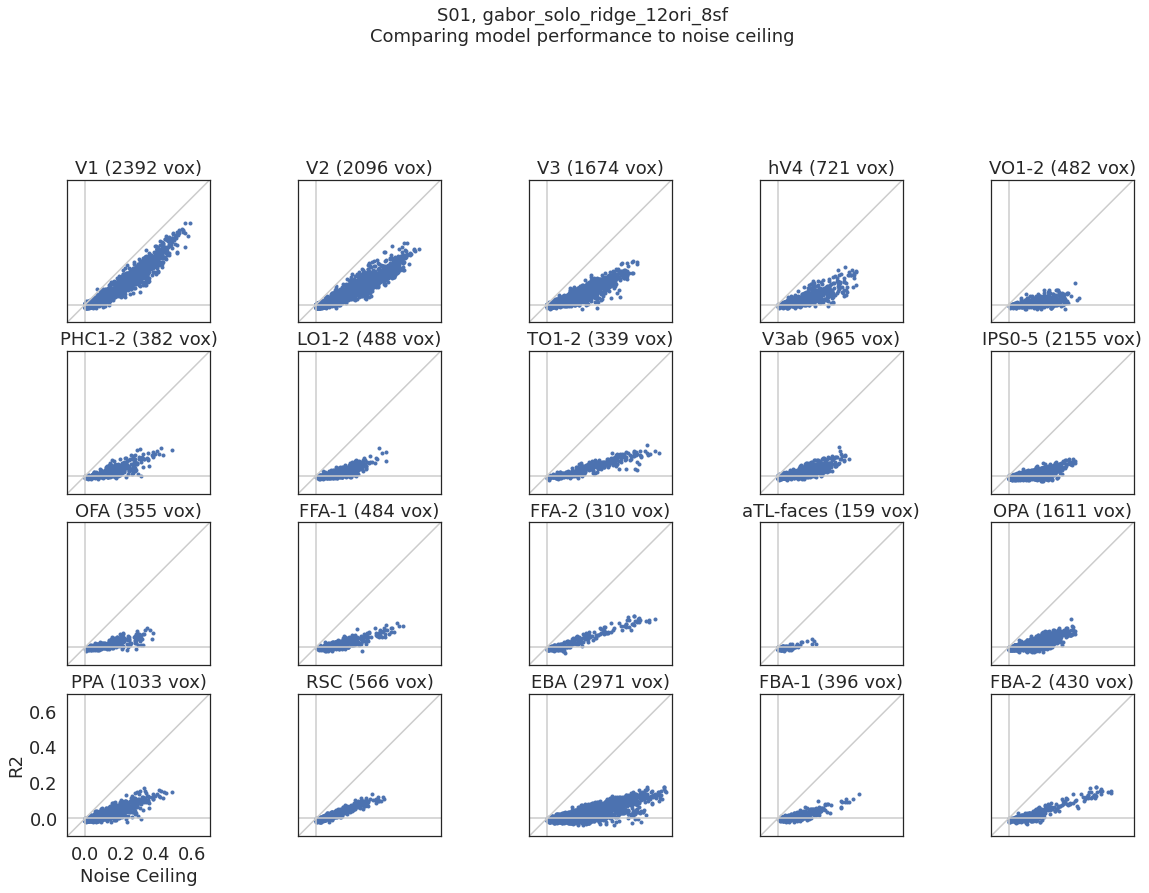

In [5]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder, fig_size=(20,24))

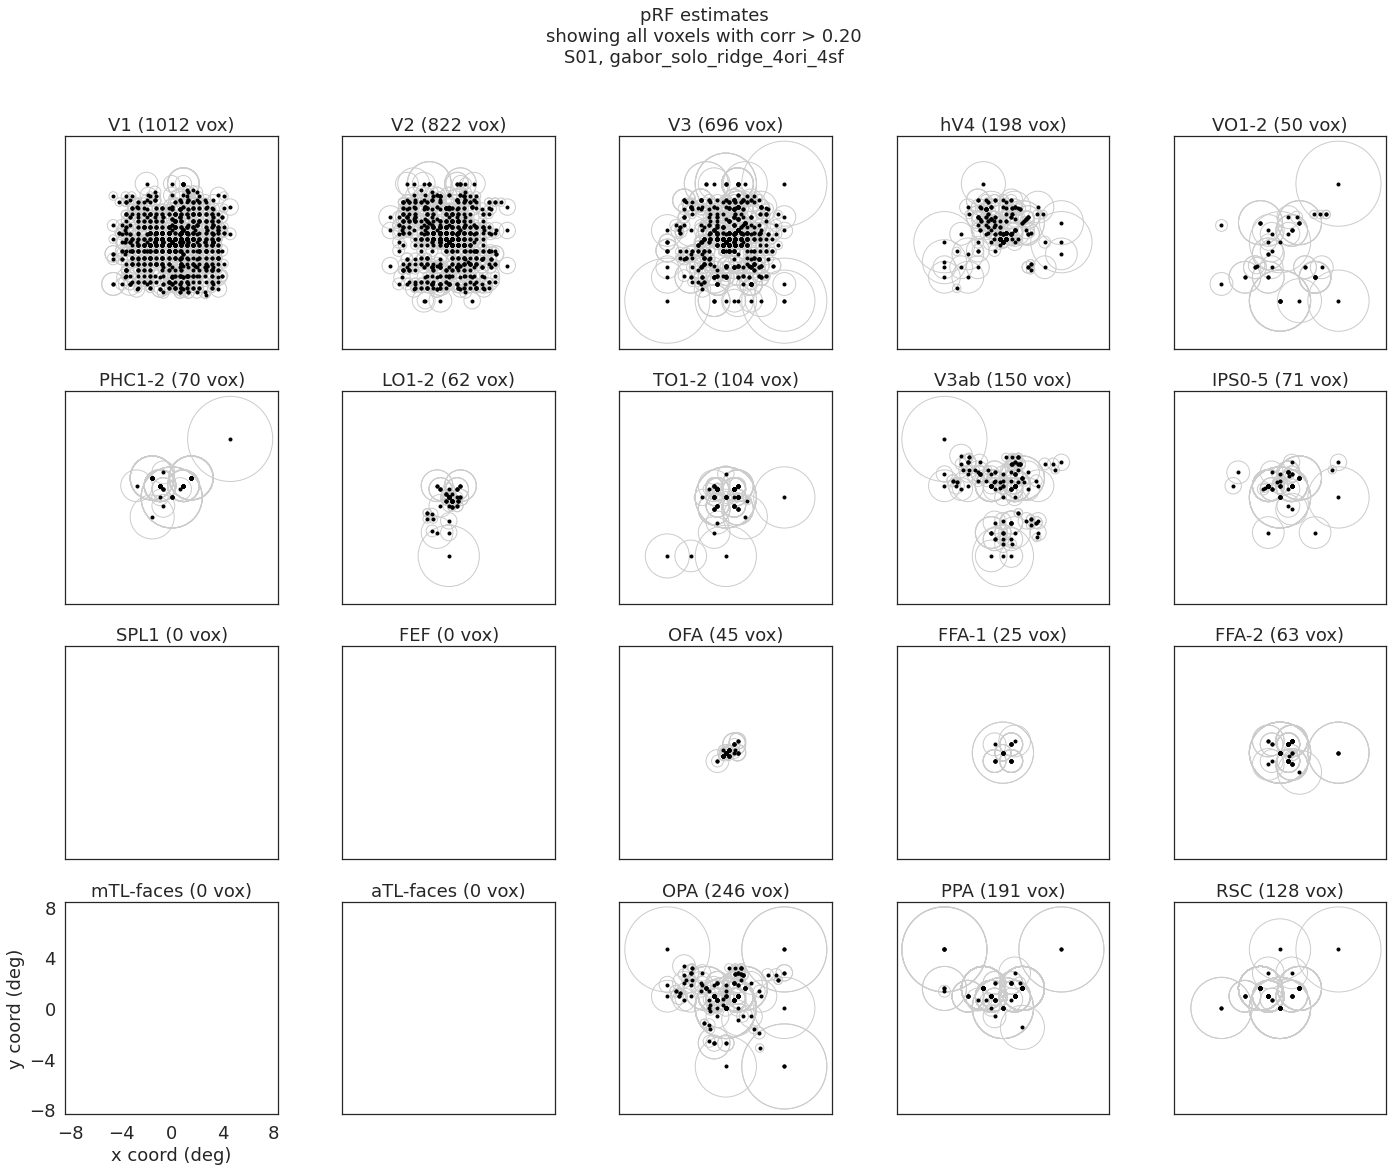

In [5]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

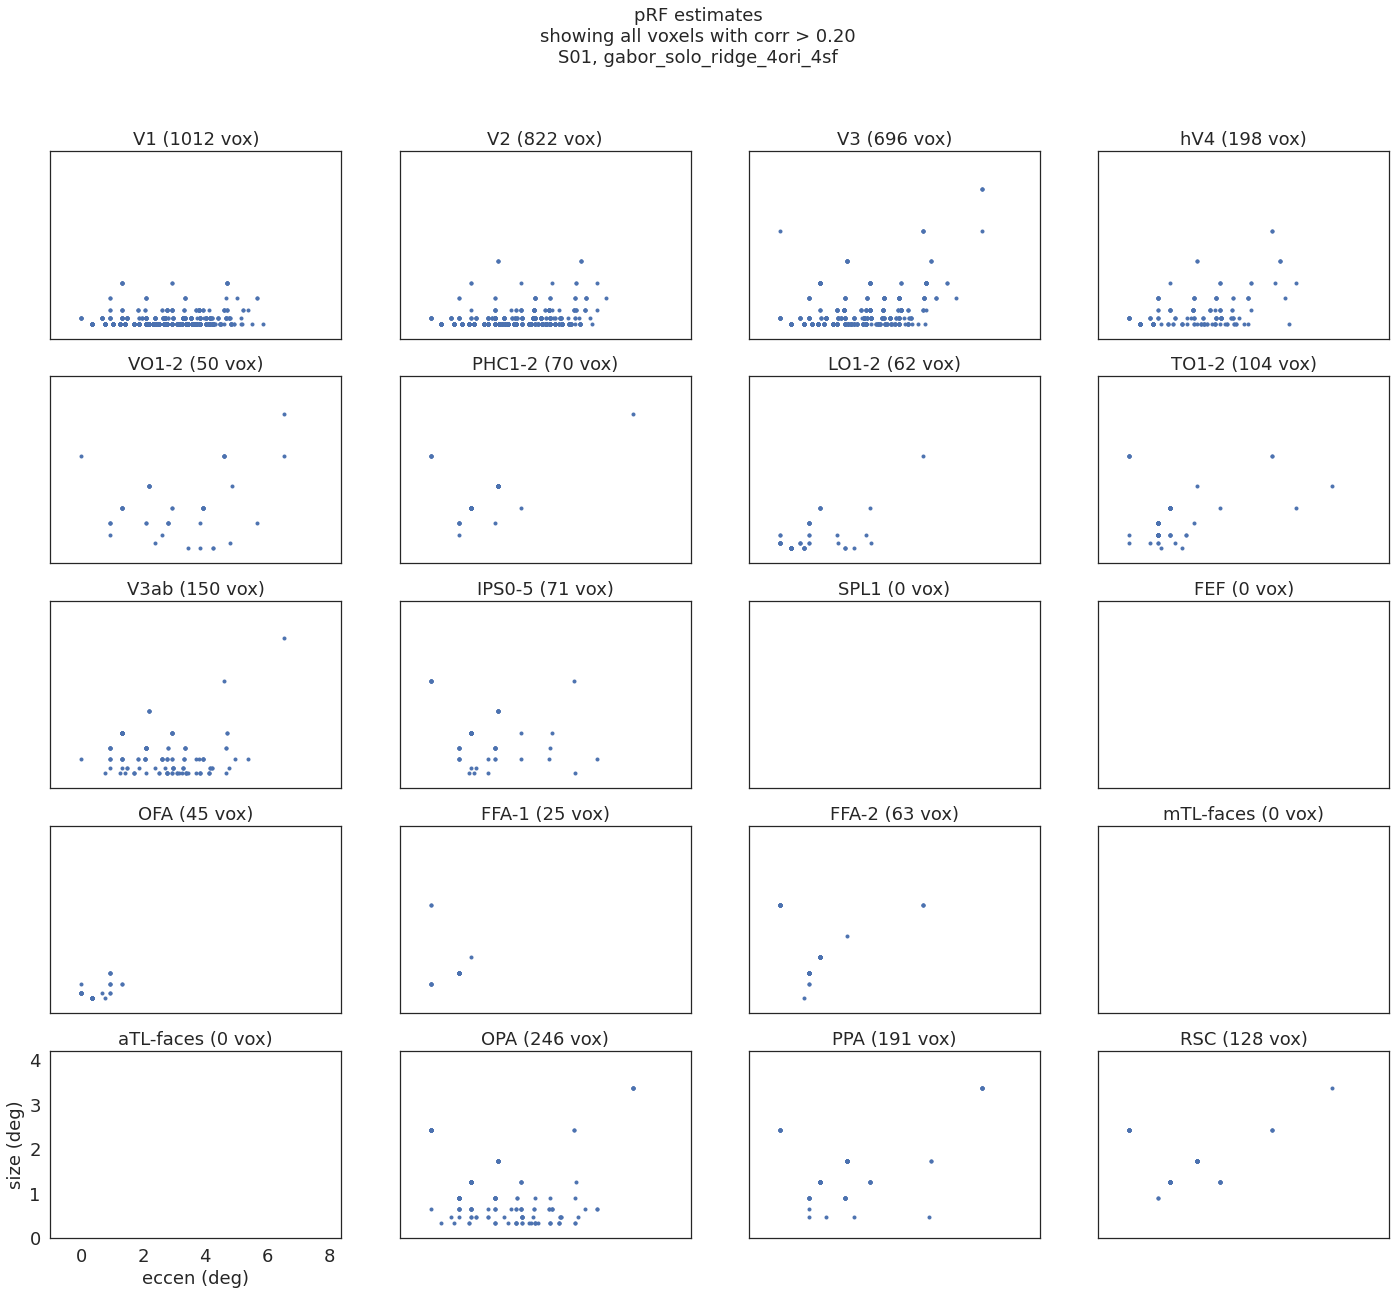

In [3]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

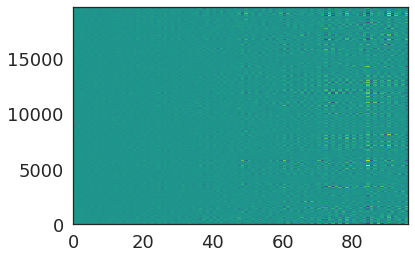

In [15]:
wts = out['best_params'][1]
plt.figure();
plt.pcolormesh(wts[:,:,0])

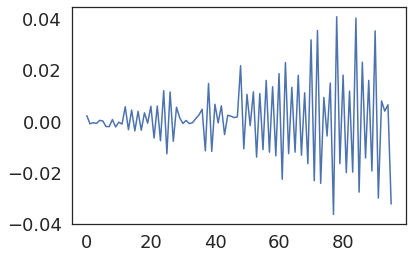

In [16]:
plt.figure();
plt.plot(np.mean(wts[:,:,0], axis=0))

In [216]:
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


In [15]:
cyc_per_deg

array([0.35714286, 0.56236075, 0.88549892, 1.39431555, 2.19550336,
       3.45706178, 5.44352442, 8.57142857])

In [12]:
cyc_per_stim

array([ 3.        ,  4.72383032,  7.43819096, 11.71225066, 18.44222825,
       29.03931899, 45.72560516, 72.        ])

In [6]:
cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
cyc_per_stim = np.unique(cyc_per_stim)
screen_eccen_deg=8.4
cyc_per_deg = cyc_per_stim/screen_eccen_deg

orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orients_deg = np.unique(orients_deg)

feature_weights = out['best_params'][1][:,:,0]
feature_corr = out['corr_each_feature']
n_voxels = feature_weights.shape[0]
n_ori = len(np.unique(orients_deg))
n_sf = len(np.unique(cyc_per_stim))

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

preferred_ori_corr = np.argmax(mean_orient_corr, axis=1)
preferred_sf_corr = np.argmax(mean_sf_corr, axis=1)

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1)
preferred_sf_weights = np.argmax(mean_sf_weights, axis=1)

(19738, 12)
(19738, 8)
(19738, 12)
(19738, 8)


In [7]:
# Make plots in pycortex 

import cortex

port=33333

vox2plot = out['val_r2'][:,0]>-100

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['gabor model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

maps += [orients_deg[preferred_ori_corr], cyc_per_deg[preferred_sf_corr]]
names += ['Preferred orientation (deg)', 'Preferred spatial frequency (cyc/deg)']
cmaps += ['Retinotopy_RYBCR', 'viridis']
mins += [0, 0]
maxes += [180, 9]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


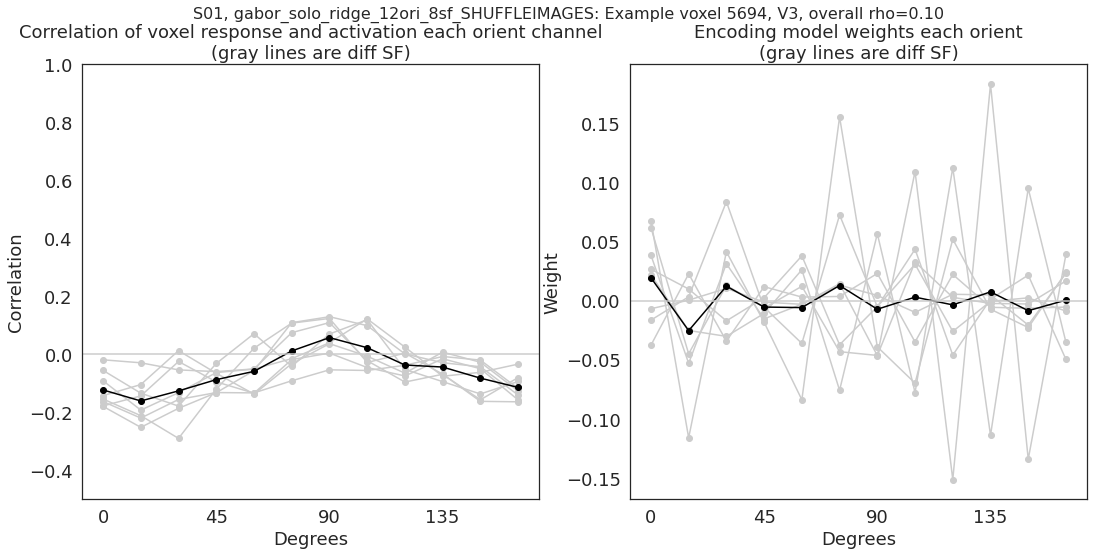

In [220]:
# Plotting orientation tuning for one example voxel

val_cc = out['val_cc'][:,0]
orients_deg
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
if ~np.isnan(retlabs[vidx]):
    rname = ret_names[int(retlabs[vidx])]
elif ~np.isnan(facelabs[vidx]):
    rname = face_names[int(facelabs[vidx])]
elif ~np.isnan(placelabs[vidx]):
    rname = place_names[int(placelabs[vidx])]
elif ~np.isnan(bodylabs[vidx]):
    rname = body_names[int(bodylabs[vidx])]
else:
    raise ValueError('vidx not found')
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg, allcorr_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  mean_orient_corr[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
plt.ylim([-0.5,1])

plt.subplot(1,2,2)
plt.plot(orients_deg, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f'%( subject, \
               fitting_type, vidx, rname, val_cc[vidx]),fontsize=16);



In [223]:
val_r2

array([-0.01076331,  0.00112293, -0.00269558, ..., -0.00337687,
       -0.0019498 ,  0.00315763], dtype=float32)

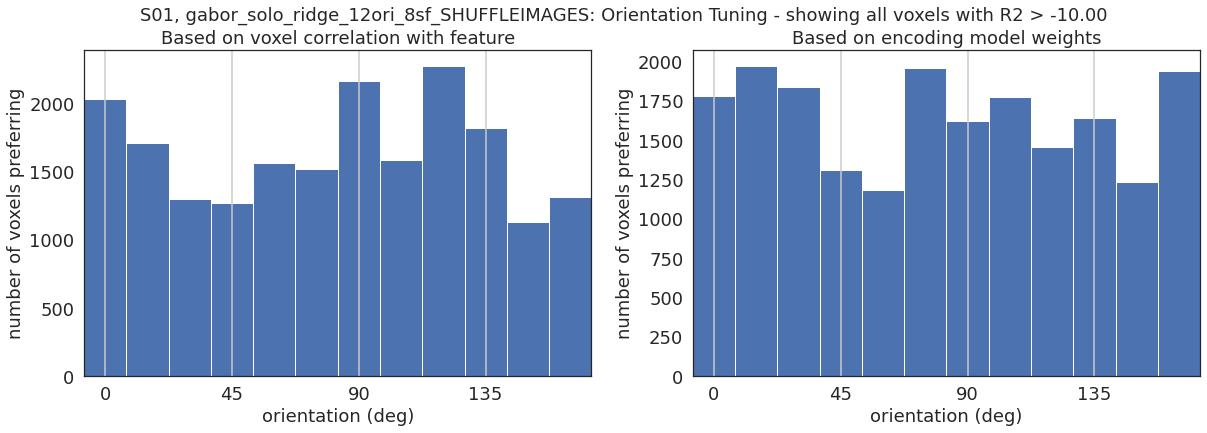

In [224]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

r2_cutoff = -10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.subplot(1,2,1)
spacing = orients_deg[1] - orients_deg[0]
neach = [np.sum(preferred_ori_corr[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(orients_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.subplot(1,2,2)
neach = [np.sum(preferred_ori_weights[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(orients_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
     
plt.suptitle('S%02d, %s: Orientation Tuning - showing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff));

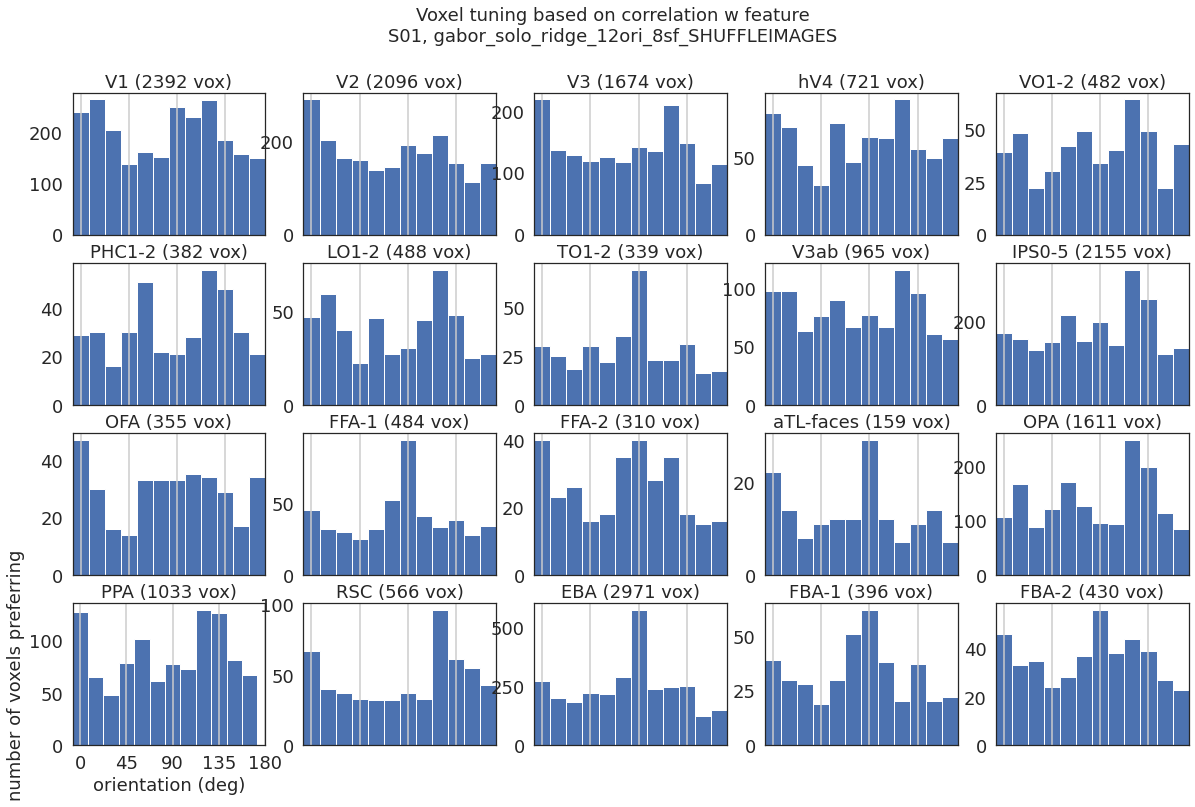

In [226]:

r2_cutoff = -10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = orients_deg[1] - orients_deg[0]
        neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
        plt.bar(orients_deg, neach, width=spacing)
        
        plt.xlim([-spacing/2,180-spacing/2])

#         print(pi)
        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('number of voxels preferring')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
    #         plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


In [200]:
out['discrim_each_axis'].shape

(19738, 6)

In [227]:
discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan

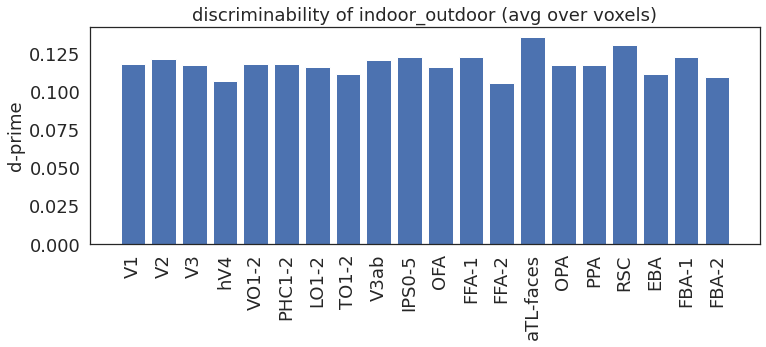

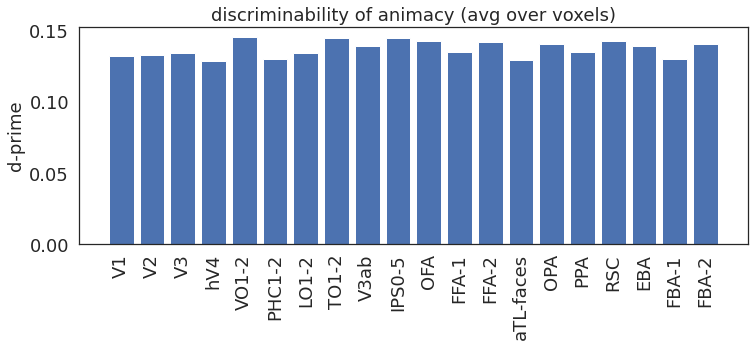

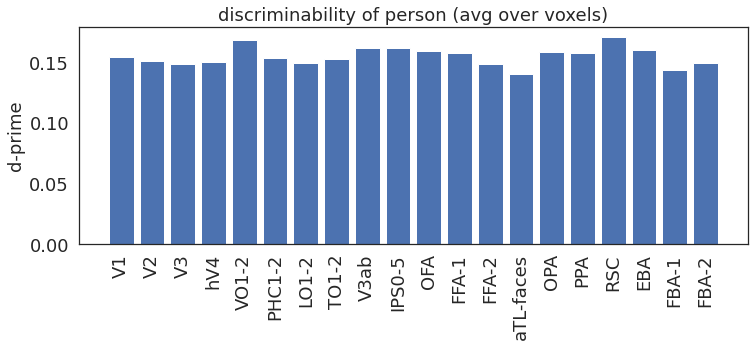

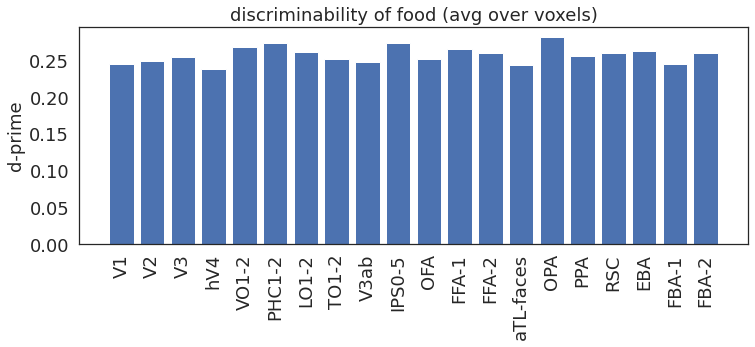

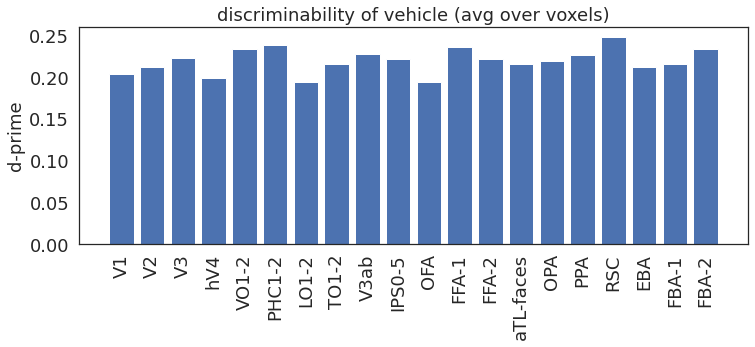

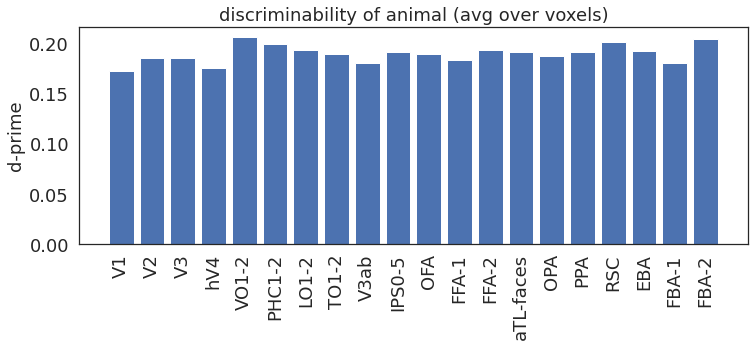

In [228]:

for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
#     plt.ylim([0,2])

In [55]:
constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)

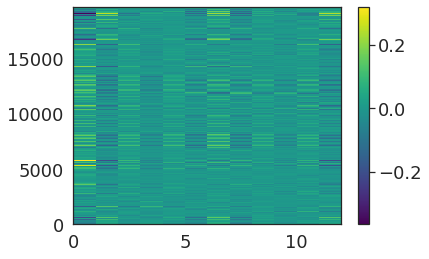

In [58]:
plt.figure();
plt.pcolormesh(mean_orient_weights)
plt.colorbar()

In [145]:
# Trying to load gratings and see how the model will respond to them. 
# not very helpful

act_orients = np.arange(0,180,5)
n_images = len(act_orients)
image_batch = np.zeros((n_images, 1, 224, 224))

for ii, orient in enumerate(act_orients):
    imfn = '/user_data/mmhender/grating_ims/Grating_ex0_phase0_%ddeg.png'%orient
    from PIL import Image

    im = Image.open(imfn)
    image_batch[ii,0,:,:] = np.squeeze(np.array(im)[:,:,0])

In [146]:
image_batch.shape

(36, 1, 224, 224)

In [85]:
image_data = np.array(im)
image_data = image_data[np.newaxis, np.newaxis, :,:,0]
image_data.shape

(1, 1, 224, 224)

In [96]:
from model_fitting import initialize_fitting
from feature_extraction import texture_statistics_gabor
from utils import prf_utils

In [148]:
# Set up the Gabor filtering modules
n_ori = 12
n_sf = 8
padding_mode = 'circular'
device = 'cpu:0'
nonlin_fn = False
batch_size=100;
autocorr_output_pix=5 
n_prf_sd_out=2

# Params for the spatial aspect of the model (possible pRFs)
aperture = 1.0
aperture_rf_range = 1.1
which_prf_grid = 4
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, which_grid = which_prf_grid)   

do_varpart=False # this doesn't do anything here
group_all_hl_feats = False # this doesn't do anything here
compute_features = True
feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']

_gabor_ext_complex, _gabor_ext_simple, _fmaps_fn_complex, _fmaps_fn_simple = \
        initialize_fitting.get_gabor_feature_map_fn(n_ori, n_sf, padding_mode=padding_mode, device=device, \
                                                             nonlin_fn=nonlin_fn);    
# Initialize the "texture" model which builds on first level feature maps

_feature_extractor = texture_statistics_gabor.texture_feature_extractor(_fmaps_fn_complex, _fmaps_fn_simple, \
                                        sample_batch_size=batch_size, autocorr_output_pix=autocorr_output_pix, \
                                        n_prf_sd_out=n_prf_sd_out, aperture=aperture, \
                                        feature_types_exclude=feature_types_exclude, do_varpart=do_varpart, \
                                        group_all_hl_feats=group_all_hl_feats, device=device)      
n_pix = image_data.shape[2]
_feature_extractor.init_for_fitting((n_pix, n_pix), models, device)
n_features = _feature_extractor.n_features_total
print('number of features total: %d'%n_features)

number of pRFs: 1684
most extreme RF positions:
[0.   0.   0.04]
[ 1.2934314  -0.53575677  1.        ]
Feature types to exclude from the model:
['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs', 'complex_within_scale_crosscorrs', 'simple_within_scale_crosscorrs', 'complex_across_scale_crosscorrs', 'simple_across_scale_crosscorrs', 'complex_feature_autocorrs', 'simple_feature_autocorrs', 'pixel_stats']
number of features total: 96


In [100]:
mm=488
print(models[488,:])
center = [models[mm,0], models[mm,1]]
sd = models[mm,2]
patch_size = n_pix
prf = prf_utils.gauss_2d(center, sd, patch_size)

plt.figure();
plt.pcolormesh(prf);
plt.axis('square');
plt.axis('off');

In [150]:
features, _ = _feature_extractor(image_batch/255, models[mm],mm)
features = features.detach().cpu().numpy()

Computing complex cell features...
time elapsed = 3.26808
SKIPPING HIGHER-ORDER CORRELATIONS...
time elapsed = 0.00029
Final size of features concatenated is [36 x 96]
Feature types included are:
['complex_feature_means']


In [151]:
features.shape

(36, 96)

In [168]:
channels_to_use = np.arange(n_ori*3,n_ori*6)
channels_to_use

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71])

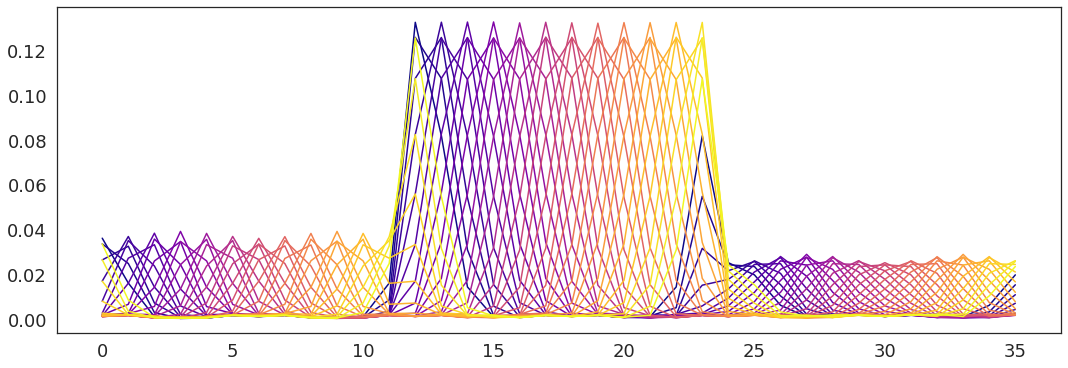

In [169]:
plt.figure(figsize=(18,6));
colors = cm.plasma(np.linspace(0,1,n_images))
for ii in range(n_images):
    plt.plot(features[ii,channels_to_use],color=colors[ii,:])

In [152]:
val_cc = out['val_cc'][:,0]
orients_deg
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
wts = out['best_params'][1][vidx,:,0]
wts.shape

(96,)

In [170]:
resp = features[:,channels_to_use] @ wts[channels_to_use]
resp

array([0.00653255, 0.00565683, 0.00421731, 0.00294491, 0.00265601,
       0.00352382, 0.00508923, 0.00634842, 0.00682211, 0.00691659,
       0.00680249, 0.00683298, 0.00692083, 0.00686036, 0.00661247,
       0.00645534, 0.00666078, 0.00715624, 0.00767854, 0.00807552,
       0.00817822, 0.00806591, 0.00785957, 0.00749965, 0.00694118,
       0.00636488, 0.00611505, 0.00653547, 0.00749587, 0.00834967,
       0.00816638, 0.00705511, 0.00599444, 0.00567818, 0.00611459,
       0.00660765], dtype=float32)

In [196]:
act_orients = np.arange(0,180,15)
inds = (act_orients/15).astype('int')
n_images = len(act_orients)
features = np.zeros((n_images,96))
for ii in range(n_images):
    features[ii,np.arange(inds[ii],96,n_ori)] = 1
    features[ii,np.arange(inds[ii]-1,96,n_ori)] = 0.8
    features[ii,np.arange(inds[ii]+1,96,n_ori)] = 0.8
resp = features @ wts

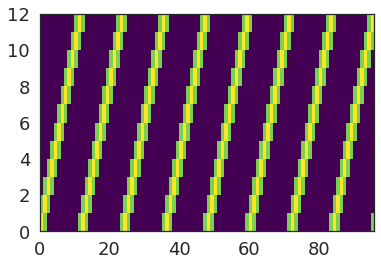

In [197]:
plt.figure();
plt.pcolormesh(features)

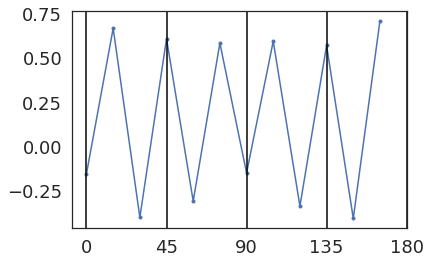

In [198]:
plt.figure();
plt.plot(act_orients, resp, '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

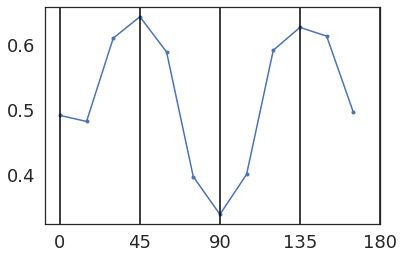

In [162]:
plt.figure();
plt.plot(orients_deg, mean_orient_corr[vidx,:], '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

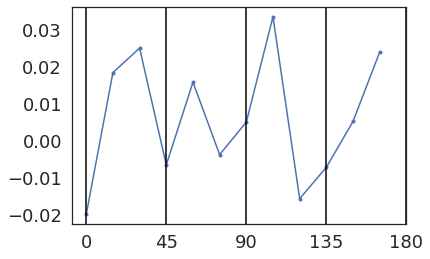

In [189]:
plt.figure();
plt.plot(orients_deg, allw_reshaped[vidx,:,0], '.-')
# plt.plot(orients_deg, mean_orient_weights[vidx,:], '.-')
plt.xticks(np.arange(0,181,45));
for oo in np.arange(0,181,45):
    plt.axvline(oo,color='k')

In [122]:
image_data

array([[[[124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         ...,
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124],
         [124, 124, 124, ..., 124, 124, 124]]]], dtype=uint8)

In [112]:
image_data.shape

(1, 1, 224, 224)

In [172]:
np.arange(0,96,n_ori)

array([ 0, 12, 24, 36, 48, 60, 72, 84])

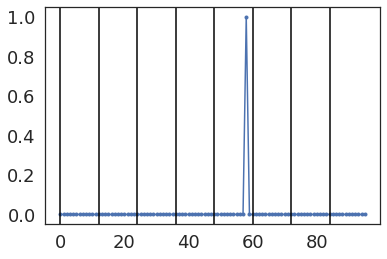

In [177]:
plt.figure();
plt.plot(features, '.-');
for sf in range(n_sf):
    plt.axvline(n_ori*sf, color='k')

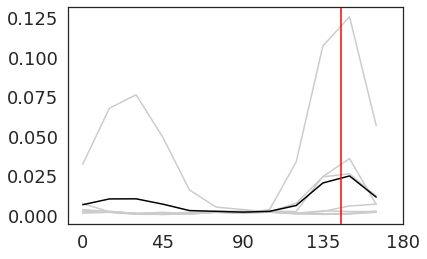

In [132]:
plt.figure();
features_reshaped = np.reshape(features, [n_ori, n_sf], order='F')
plt.plot(orients_deg, features_reshaped,color=[0.8, 0.8, 0.8]);
plt.plot(orients_deg,np.mean(features_reshaped, axis=1),color='k')
plt.xticks(np.arange(0,181,45));
plt.axvline(act_orient, color='r')
# for sf in range(n_sf):
#     plt.axvline(n_ori*sf, color='k')

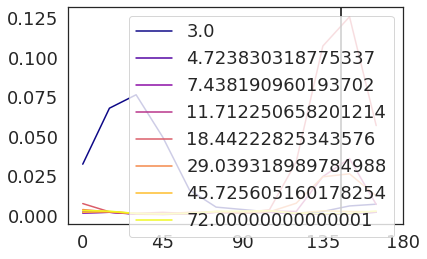

In [137]:
plt.figure();
features_reshaped = np.reshape(features, [n_ori, n_sf], order='F')
colors = cm.plasma(np.linspace(0,1,n_sf))
for sf in range(n_sf):
    plt.plot(orients_deg, features_reshaped[:,sf],color=colors[sf,:]);
# plt.plot(orients_deg,np.mean(features_reshaped, axis=1),color='k')
plt.xticks(np.arange(0,181,45));
plt.axvline(act_orient, color='k')
# for sf in range(n_sf):
#     plt.axvline(n_ori*sf, color='k')

plt.legend(cyc_per_stim)